## Predicting the next word

In [61]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from keras.models import Sequential
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, Dropout, Embedding, Bidirectional 

import pickle

In [2]:
SONNETs_FILE = './sonnets.txt'

with open('./sonnets.txt') as f:
    data = f.read()

corpus = data.lower().split('\n')

len(corpus)

2159

In [12]:
[corpus[i] for i in range(5)]

['from fairest creatures we desire increase,',
 "that thereby beauty's rose might never die,",
 'but as the riper should by time decease,',
 'his tender heir might bear his memory:',
 'but thou, contracted to thine own bright eyes,']

### Preprocess the corpus

In [20]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1 # because the word indices start from 1 (not 0), due to the deign of Tokenizer

In [28]:
corpus[0]

'from fairest creatures we desire increase,'

In [26]:
tokenizer.texts_to_sequences(corpus[0]) 

# Because, the text_to_sequences expects a list and we are providing a string. But string is still iterable in python.


[[],
 [],
 [58],
 [],
 [],
 [],
 [17],
 [6],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [17],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [6],
 [],
 [],
 [],
 [6],
 [],
 [],
 [],
 [],
 [17],
 [],
 [],
 []]

In [29]:
tokenizer.texts_to_sequences([corpus[0]]) # pass as list

[[34, 417, 877, 166, 213, 517]]

In [30]:
tokenizer.texts_to_sequences([corpus[0]])[0]

[34, 417, 877, 166, 213, 517]

In [32]:
tokenizer.texts_to_sequences(corpus)

[[34, 417, 877, 166, 213, 517],
 [8, 878, 134, 351, 102, 156, 199],
 [16, 22, 2, 879, 61, 30, 48, 634],
 [25, 311, 635, 102, 200, 25, 278],
 [16, 10, 880, 3, 62, 85, 214, 53],
 [1372, 9, 1373, 636, 11, 122, 1374, 1375],
 [201, 17, 1376, 64, 518, 202],
 [118, 9, 1377, 3, 9, 47, 122, 135, 279],
 [10, 8, 54, 63, 2, 418, 312, 419],
 [1, 352, 1378, 3, 2, 1379, 420],
 [215, 62, 85, 881, 1380, 9, 882],
 [1, 311, 883, 884, 313, 7, 1381],
 [257, 2, 94, 36, 353, 29, 1382, 21],
 [3, 637, 2, 418, 354, 30, 2, 638, 1, 19],
 [27, 1383, 885, 46, 1384, 9, 280],
 [1, 1385, 281, 1386, 7, 9, 134, 1387],
 [9, 1388, 179, 1389, 20, 1390, 35, 63],
 [49, 21, 17, 886, 639, 4, 887, 126, 888],
 [38, 81, 1391, 64, 23, 9, 51, 202],
 [64, 23, 2, 258, 4, 9, 889, 145],
 [3, 95, 215, 62, 85, 281, 1392, 53],
 [86, 146, 23, 1393, 236, 1, 1394, 96],
 [71, 136, 43, 96, 1395, 9, 134, 186],
 [42, 10, 1396, 640, 890, 69, 282, 4, 44],
 [46, 519, 5, 520, 1, 65, 5, 112, 314, 147],
 [1397, 25, 51, 30, 1398, 62],
 [29, 86, 3, 21, 

In [41]:
def n_gram_steps(corpus, tokenizer):
    input_sequence = []
    
    for line in corpus:
        token_list = tokenizer.texts_to_sequences([line])[0]
        
        for i in range(1, len(token_list)):
            n_gram_sequence = token_list[:i+1] # these are input seq in the model and it should predict the next word
            input_sequence.append(n_gram_sequence)
        
    return input_sequence

input_sequence = n_gram_steps(corpus, tokenizer)
max_sequence_len = max([len(x) for x in input_sequence])

len(input_sequence), max_sequence_len

(15462, 11)

In [44]:
input_sequence[:10]

[[34, 417],
 [34, 417, 877],
 [34, 417, 877, 166],
 [34, 417, 877, 166, 213],
 [34, 417, 877, 166, 213, 517],
 [8, 878],
 [8, 878, 134],
 [8, 878, 134, 351],
 [8, 878, 134, 351, 102],
 [8, 878, 134, 351, 102, 156]]

In [45]:
def pad_seqs(input_sequences, max_len):
    padded_sequence = pad_sequences(input_sequence, maxlen=max_len, padding='pre')
    return padded_sequence

input_sequence = pad_seqs(input_sequence, max_sequence_len)

input_sequence.shape

(15462, 11)

In [57]:
total_words

3211

In [56]:
def features_and_labels(input_sequence, total_words):
    features = input_sequence[:, :-1]
    labels = input_sequence[:, -1]
    one_hot_labels = to_categorical(labels, num_classes=total_words)
    return features, one_hot_labels

features, labels = features_and_labels(input_sequence, total_words)

features.shape, labels.shape

((15462, 10), (15462, 3211))

In [59]:
def create_model(total_words, max_sequence_len):
    # Funtional API
    model = Sequential()
    model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
    model.add(Bidirectional(LSTM(150)))
    model.add(Dense(total_words, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

model = create_model(total_words, max_sequence_len)

history = model.fit(features, labels, epochs=50, verbose=1)

2023-10-09 19:59:37.974175: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2023-10-09 19:59:37.974254: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: mr-freak
2023-10-09 19:59:37.974260: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: mr-freak
2023-10-09 19:59:37.974383: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 535.113.1
2023-10-09 19:59:37.974410: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 535.113.1
2023-10-09 19:59:37.974414: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 535.113.1


Epoch 1/50
484/484 [==============================] - 11s 19ms/step - loss: 6.8764 - accuracy: 0.0233
Epoch 2/50
484/484 [==============================] - 10s 20ms/step - loss: 6.4397 - accuracy: 0.0316
Epoch 3/50
484/484 [==============================] - 9s 18ms/step - loss: 6.2101 - accuracy: 0.0426
Epoch 4/50
484/484 [==============================] - 10s 20ms/step - loss: 5.9453 - accuracy: 0.0521
Epoch 5/50
484/484 [==============================] - 10s 21ms/step - loss: 5.6287 - accuracy: 0.0624
Epoch 6/50
484/484 [==============================] - 11s 23ms/step - loss: 5.2797 - accuracy: 0.0740
Epoch 7/50
484/484 [==============================] - 10s 20ms/step - loss: 4.8991 - accuracy: 0.0938
Epoch 8/50
484/484 [==============================] - 10s 20ms/step - loss: 4.4938 - accuracy: 0.1276
Epoch 9/50
484/484 [==============================] - 10s 20ms/step - loss: 4.0893 - accuracy: 0.1724
Epoch 10/50
484/484 [==============================] - 9s 19ms/step - loss: 3.6847 

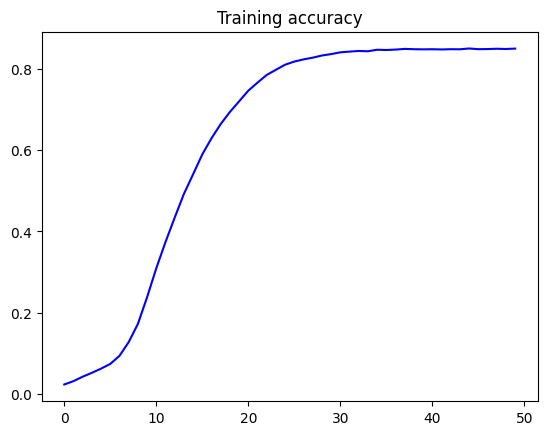

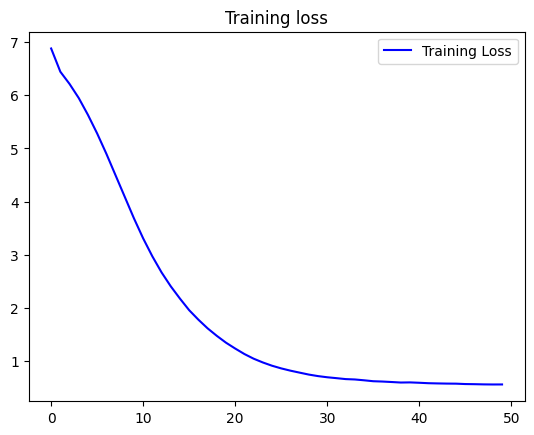

In [60]:
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [62]:
with open('history.pkl', 'wb') as file:
    pickle.dump(history.history, file)

In [64]:
seed_text = "I am in love with you"
next_words = 50
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = model.predict(token_list, verbose=0)
	predicted = np.argmax(predicted, axis=-1).item()
	output_word = tokenizer.index_word[predicted]
	seed_text += " " + output_word

print(seed_text)

I am in love with you of things to show it to art away to blind art and me see thee the fair fair may go approve on thee dear friend ' to me behold be rare the tomb the story must be grew i night of one of you new prove to lie to thee
